In [ ]:
# ========================
# Python Libraries
# ========================
import os
import re
import pickle
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
from collections import defaultdict
from textwrap import fill
import matplotlib.pyplot as plt
from matplotlib import gridspec
from PIL import Image

# ========================
# PyTorch Libraries
# ========================
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence

# ========================
# torchvision Libraries
# ========================
import torchvision.models as models
import torchvision.transforms as transforms

# ========================
# TensorFlow / Keras Libraries
# ========================
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.image import load_img, img_to_array, save_img, ImageDataGenerator
from tensorflow.keras.applications.densenet import preprocess_input
from keras.models import Model
from keras.layers import Input, GlobalAveragePooling2D
from keras.applications.densenet import DenseNet121

# ========================
# Scikit-learn
# ========================
from sklearn.preprocessing import LabelBinarizer

# ========================
# Device Setup
# ========================
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# ========================
# Directory Setup
# ========================
BASE_DIR = '/kaggle/input/chest-xrays-indiana-university'
WORKING_DIR = '/kaggle/working'


In [ ]:

# ------------------------------
# Step 1: Load and Organize Captions from Impression Only
# ------------------------------

# Define base directory
base_dir = '/kaggle/input/chest-xrays-indiana-university'

# Load CSV files
projections = pd.read_csv(os.path.join(base_dir, 'indiana_projections.csv'))
reports = pd.read_csv(os.path.join(base_dir, 'indiana_reports.csv'))

# Merge the two datasets on 'uid'
merged = pd.merge(projections, reports, on='uid')

# Build a mapping: image ID → list of impression texts
mapping = defaultdict(list)

for _, row in merged.iterrows():
    filename = row.get('filename')
    impression = str(row.get('impression') or '').strip()

    if filename:
        base_filename = filename.split('.')[0]
        if impression:
            mapping[base_filename].append(impression)


In [4]:

def clean(mapping):
    cleaned_mapping = {}

    for key, texts in mapping.items():
        for text in texts:
            # Remove leading numbers like "1. ..."
            text = re.sub(r'^\d+\.\s*', '', text)

            # Split into sentences
            sentences = re.split(r'\.\s*', text)

            for sentence in sentences:
                sentence = sentence.strip()
                if not sentence:
                    continue

                # Lowercase and remove non-alphabetic characters
                sentence = sentence.lower()
                sentence = re.sub(r'[^a-z\s]', '', sentence)
                sentence = re.sub(r'\s+', ' ', sentence).strip()

                # Remove words containing more than two consecutive 'x'
                words = sentence.split()
                words = [word for word in words if not re.search(r'x{3,}', word)]

                # Remove short words (length ≤ 1)
                words = [word for word in words if len(word) > 1]

                # Add cleaned caption if valid
                if words:
                    cleaned_caption = 'startseq ' + ' '.join(words) + ' endseq'
                    cleaned_mapping[key] = cleaned_caption
                    break  # Keep only the first valid caption

    return cleaned_mapping

# Clean the captions
cleaned_mapping = clean(mapping)


In [5]:
mapping['146_IM-0298-2001']


['Heart size and mediastinal contour are stable and within normal limits allowing for rotation. Pulmonary vascularity is normal.&gt;] Lung volumes are low. No focal airspace disease or effusion. Expansile lesion of the right posterior 9th rib XXXX represents sequelae of known multiple myeloma.']

In [25]:
cleaned_mapping['146_IM-0298-2001']


'startseq heart size and mediastinal contour are stable and within normal limits allowing for rotation endseq'

In [10]:
# Set a seed for reproducibility
random.seed(42)

# Convert the cleaned_mapping dict into a list of (image_id, captions) pairs
items = list(cleaned_mapping.items())

# Shuffle the list in-place
random.shuffle(items)

# Define your test set size
test_size = 1250

# Split into test and train
test_items = items[:test_size]
train_items = items[test_size:]

# Convert back to dicts
test_mapping = dict(test_items)
train_mapping = dict(train_items)

# Optional: inspect sizes
print("Train samples:", len(train_mapping))
print("Test samples:", len(test_mapping))

Train samples: 6216
Test samples: 1250


In [11]:

# Function to perform a random crop on an image array
def random_crop(img, target_size=(224, 224)):
    """
    Randomly crops the input image array to the target size.
    img: numpy array of shape (H, W, C)
    target_size: tuple (height, width)
    """
    h, w, _ = img.shape
    th, tw = target_size
    if h == th and w == tw:
        return img
    top = np.random.randint(0, h - th + 1)
    left = np.random.randint(0, w - tw + 1)
    return img[top: top + th, left: left + tw, :]

# Paths and setup
original_train_dir = '/kaggle/input/chest-xrays-indiana-university/images/images_normalized'
augmented_dir = os.path.join(WORKING_DIR, 'augmented_images')  # ذخیره در دایرکتوری قابل نوشتن

if not os.path.exists(augmented_dir):
    os.makedirs(augmented_dir)

# Data augmentation configuration
data_gen = ImageDataGenerator(
    rotation_range=25,
    width_shift_range=0.15,
    height_shift_range=0.15,
    brightness_range=[0.7, 1.4],
    zoom_range=[0.85, 1.25],
    shear_range=15,
    horizontal_flip=True,
    fill_mode='nearest'
)

# New mapping for augmented samples
augmented_train_mapping = {}

for img_id, caption in tqdm(train_mapping.items(), total=len(train_mapping), desc="Augmenting images", unit="image"):
    # Detect image file
    img_path = os.path.join(original_train_dir, img_id + '.dcm.png')


    # Create 3 versions: 2 normal augmented, 1 with crop
    for i in range(1, 4):
        target_size = (256, 256) if i == 3 else (224, 224)

        img = load_img(img_path, target_size=target_size)
        x = img_to_array(img)
        x = np.expand_dims(x, axis=0)

        aug_img_array = next(data_gen.flow(x, batch_size=1, shuffle=False))[0].astype('uint8')

        if i == 3:
            aug_img_array = random_crop(aug_img_array, target_size=(224, 224))

        # Save new image
        new_img_id = f"{img_id}_aug{i}"
        new_img_path = os.path.join(augmented_dir, new_img_id + '.jpg')
        save_img(new_img_path, aug_img_array)

        # Assign same caption as original (caption is str, not list)
        augmented_train_mapping[new_img_id] = caption

# Merge
combined_train_mapping = {**train_mapping, **augmented_train_mapping}

print("✅ Number of augmented images:", len(augmented_train_mapping))
print("✅ Total train samples after merge:", len(combined_train_mapping))

Augmenting images: 100%|██████████| 6216/6216 [19:21<00:00,  5.35image/s]

✅ Number of augmented images: 18648
✅ Total train samples after merge: 24864


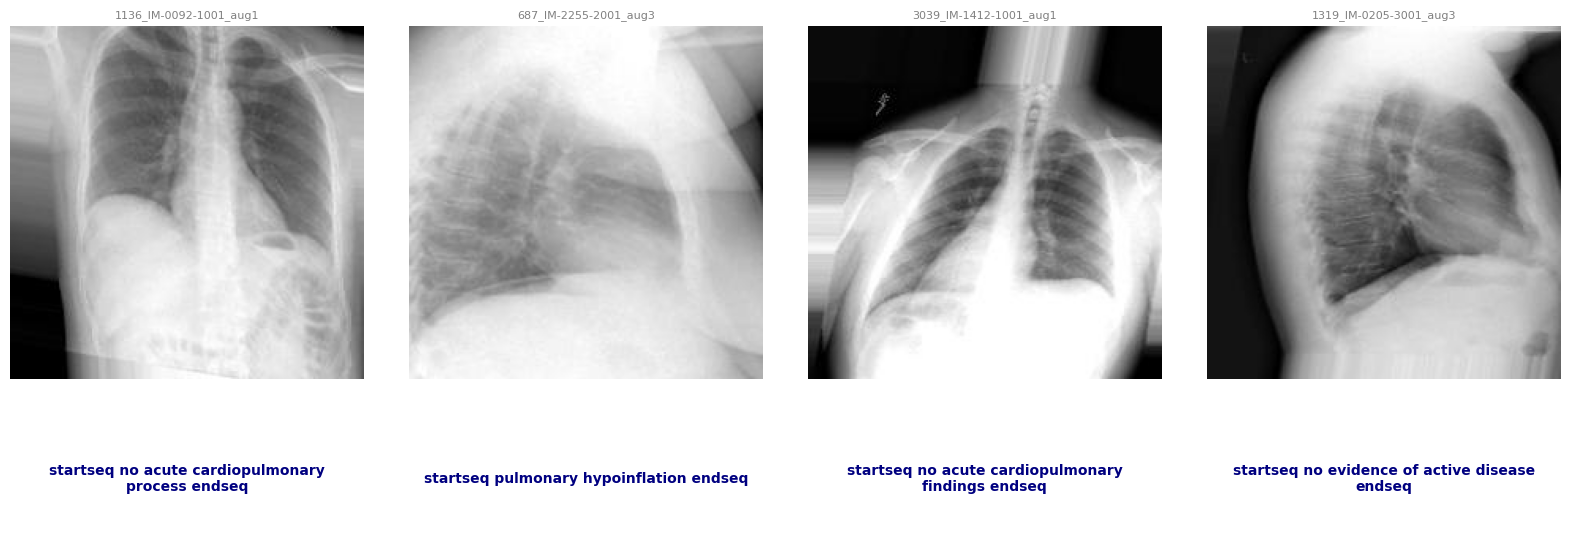

In [26]:


def build_feature_extractor(input_shape=(224, 224, 3), weights_path=None):
    input_layer = Input(shape=input_shape, name='input_1')
    
    # Load DenseNet121 without fully connected layers
    base_model = DenseNet121(weights=None, include_top=False, input_tensor=input_layer)

    # Load pretrained CheXNet weights (optional)
    if weights_path is not None:
        base_model.load_weights(weights_path, by_name=True)

    # Add global average pooling instead of classifier
    x = base_model.output
    x = GlobalAveragePooling2D()(x)  # Output: (batch_size, 1024)

    model = Model(inputs=base_model.input, outputs=x)
    return model

# Use the model
feature_model_chexnet = build_feature_extractor(
    input_shape=(224, 224, 3),
    weights_path='/kaggle/input/chexnet-weights/brucechou1983_CheXNet_Keras_0.3.0_weights.h5'
)


In [27]:

# Set paths for original and augmented images
original_dir = '/kaggle/input/chest-xrays-indiana-university/images/images_normalized'
augmented_dir = 'augmented_images'

# Dictionary to store extracted feature vectors
train_feature_chexnet = {}

# Loop through all image IDs in the combined training mapping
for img_id in tqdm(combined_train_mapping.keys(), desc="📦 Extracting CheXNet features"):

    # Determine correct image path
    if "aug" in img_id:
        img_path = os.path.join(augmented_dir, img_id + '.jpg')
    else:
        img_path = os.path.join(original_dir, img_id + '.dcm.png')

    # Check if image file exists
    if not os.path.exists(img_path):
        print(f"⚠️ Image not found: {img_path}")
        continue

    try:
        # Load and preprocess image
        img = load_img(img_path, target_size=(224, 224), color_mode='rgb')
        x = img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)

        # Extract feature vector using CheXNet model
        feat = feature_model_chexnet.predict(x, verbose=0)

        # Flatten and store in dictionary
        train_feature_chexnet[img_id] = feat.flatten()

    except Exception as e:
        print(f"❌ Error processing {img_path}: {e}")

# Save feature vectors to a pickle file
with open("train_feature_chexnet.pkl", "wb") as f:
    pickle.dump(train_feature_chexnet, f)

print("✅ Feature extraction completed for", len(train_feature_chexnet), "images")

📦 Extracting CheXNet features: 100%|██████████| 24864/24864 [41:48<00:00,  9.91it/s] 


✅ Feature extraction completed for 24864 images


In [28]:
import os
import pickle
import numpy as np
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.densenet import preprocess_input

# Directory containing original test images
test_img_dir = '/kaggle/input/chest-xrays-indiana-university/images/images_normalized'

# Dictionary to store features
test_feature_chexnet = {}

# Loop through all image IDs in the test set
for img_id in tqdm(test_mapping.keys(), desc="📦 Extracting test set features"):
    img_path = os.path.join(test_img_dir, img_id + '.dcm.png')

    # Check if image file exists
    if not os.path.exists(img_path):
        print(f"⚠️ Image not found: {img_path}")
        continue

    try:
        # Load and preprocess image
        img = load_img(img_path, target_size=(224, 224), color_mode='rgb')
        x = img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)

        # Extract feature vector using CheXNet
        feat = feature_model_chexnet.predict(x, verbose=0)
        test_feature_chexnet[img_id] = feat.flatten()

    except Exception as e:
        print(f"❌ Error processing {img_path}: {e}")

# Save features to pickle file
with open("test_feature_chexnet.pkl", "wb") as f:
    pickle.dump(test_feature_chexnet, f)

print("✅ Feature extraction completed for", len(test_feature_chexnet), "test images.")

📦 Extracting test set features: 100%|██████████| 1250/1250 [03:25<00:00,  6.09it/s]

✅ Feature extraction completed for 1250 test images.


In [29]:
len(train_feature_chexnet)

24864

In [30]:
len(test_feature_chexnet)

1250

In [31]:
all_captions = []
for key in cleaned_mapping:
    all_captions.append(cleaned_mapping[key])

In [32]:
len(all_captions)

7466

In [33]:
all_captions[0:10]

['startseq normal chest endseq',
 'startseq normal chest endseq',
 'startseq no acute pulmonary findings endseq',
 'startseq no acute pulmonary findings endseq',
 'startseq no displaced rib fractures pneumothorax or pleural effusion identified endseq',
 'startseq no displaced rib fractures pneumothorax or pleural effusion identified endseq',
 'startseq bullous emphysema and interstitial fibrosis endseq',
 'startseq bullous emphysema and interstitial fibrosis endseq',
 'startseq no acute cardiopulmonary abnormality endseq',
 'startseq no acute cardiopulmonary abnormality endseq']

In [34]:
# tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [35]:
vocab_size  

873

In [36]:
# get maximum length of the caption available
max_length = max(len(caption.split()) for caption in all_captions)
print(max_length)


36


In [49]:
from torch.utils.data import Dataset
import torch
from keras.preprocessing.sequence import pad_sequences

class ImageCaptionDataset(Dataset):
    def __init__(self, data_keys, mapping, features, tokenizer, max_length, vocab_size):
        self.data = []
        self.features = features
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.vocab_size = vocab_size

        for key in data_keys:
            image_feature = features.get(key)
            caption = mapping.get(key)
            if caption is None or image_feature is None:
                continue

            seq = tokenizer.texts_to_sequences([caption])[0]
            for i in range(1, len(seq)):
                in_seq = seq[:i]
                out_seq = seq[i]
                # Pad input sequence
                in_seq = pad_sequences([in_seq], maxlen=max_length, padding='post')[0]
                self.data.append((image_feature, in_seq, out_seq))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        image_feature, in_seq, out_seq = self.data[index]

        # Convert features and sequences to tensors
        image_tensor = torch.tensor(image_feature, dtype=torch.float32)
        in_seq_tensor = torch.tensor(in_seq, dtype=torch.long)
        # One-hot encode the output token
        out_seq_tensor = torch.nn.functional.one_hot(
            torch.tensor(out_seq), num_classes=self.vocab_size
        ).float()

        return {"image": image_tensor, "text": in_seq_tensor}, out_seq_tensor


In [61]:
train_dataset = ImageCaptionDataset(
    data_keys=list(combined_train_mapping.keys()),
    mapping=combined_train_mapping,
    features=train_feature_chexnet,
    tokenizer=tokenizer,
    max_length=max_length,
    vocab_size=vocab_size
)

test_dataset = ImageCaptionDataset(
    data_keys=list(test_mapping.keys()),
    mapping=test_mapping,
    features=test_feature_chexnet, 
    tokenizer=tokenizer,
    max_length=max_length,
    vocab_size=vocab_size
)

In [62]:
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class EncoderDecoderModel(nn.Module):
    def __init__(self, vocab_size, max_length, embedding_dim=256, image_feature_dim=1024, lstm_units=256):
        super(EncoderDecoderModel, self).__init__()
        
        # Image feature processing
        self.image_fc1 = nn.Linear(image_feature_dim, 256)
        self.norm_image = nn.LayerNorm(256)
        self.dropout_image = nn.Dropout(0.5)

        # Text feature processing
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.dropout_text = nn.Dropout(0.5)
        self.lstm = nn.LSTM(embedding_dim, lstm_units, batch_first=True, bidirectional=True)

        # Combined feature processing
        self.dropout_combined = nn.Dropout(0.5)
        self.fc1 = nn.Linear(256 + lstm_units * 2, 256)  # Adjusted for bidirectional LSTM
        self.fc2 = nn.Linear(256, vocab_size)

    def forward(self, image_features, text_input):
        # Image path
        x_image = F.relu(self.image_fc1(image_features))
        x_image = self.norm_image(x_image)
        x_image = self.dropout_image(x_image)

        # Text path
        x_text = self.embedding(text_input)
        x_text = self.dropout_text(x_text)
        x_text, _ = self.lstm(x_text)

        # Mean pooling over time (instead of just last hidden state)
        x_text = x_text.mean(dim=1)

        # Combine
        combined = torch.cat([x_image, x_text], dim=1)
        combined = self.dropout_combined(combined)

        # Decoder
        x = F.relu(self.fc1(combined))
        output = self.fc2(x)

        return output


In [64]:
model_2 = EncoderDecoderModel(vocab_size=vocab_size, max_length=max_length).to(device)

In [65]:
from torch.optim.lr_scheduler import ReduceLROnPlateau, LambdaLR
from torch.optim import AdamW

# — Optimizer with proper weight decay —
optimizer = AdamW(model_2.parameters(),
                  lr=1e-3,            # Start with a higher learning rate
                  weight_decay=1e-2)  # Stronger regularization

# — Scheduler: warmup for initial epochs —
warmup_epochs = 5
warmup_scheduler = LambdaLR(
    optimizer,
    lr_lambda=lambda e: min(1.0, (e + 1) / warmup_epochs)
)

# — Scheduler: Reduce on plateau with refined settings —
scheduler = ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.3,         # Gentle reduction instead of aggressive halving
    patience=4,         # More patience for small fluctuations
    threshold=1e-3,     # Only consider changes larger than 0.001
    threshold_mode='rel',
    min_lr=1e-6,        # Prevent the learning rate from becoming too small
    verbose=True
)


loss_fn = nn.CrossEntropyLoss()  # Using CrossEntropyLoss for multi-class classification

In [66]:
import copy
import torch
import matplotlib.pyplot as plt

# Hyper-parameters
epochs             = 60
batch_size         = 16
print_every        = 2000
patience           = 3   # Early stopping patience
best_loss          = float('inf')
epochs_no_improve  = 0
best_model_wts     = None
warmup_epochs      = 5

# Lists to track loss history
train_loss_history = []
test_loss_history  = []

for epoch in range(1, epochs + 1):
    model_2.train()
    running_loss = 0.0
    print(f"\n🟢 Epoch [{epoch}/{epochs}] starting...\n")

    for batch_idx, (data, target) in enumerate(train_loader, start=1):
        img = data["image"].to(device)
        txt = data["text"].to(device)
        tgt = target.to(device)

        optimizer.zero_grad()
        out  = model_2(img, txt)
        loss = loss_fn(out, tgt)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if batch_idx % print_every == 0:
            pct = 100 * batch_idx / len(train_loader)
            print(f"  Batch [{batch_idx}/{len(train_loader)}] "
                  f"– Loss: {loss.item():.4f} – {pct:.1f}%")

    avg_train_loss = running_loss / len(train_loader)
    train_loss_history.append(avg_train_loss)
    print(f"✅ Epoch [{epoch}/{epochs}] Train Loss: {avg_train_loss:.4f}")

    # —— Evaluation on test set —— 
    model_2.eval()
    running_test_loss = 0.0
    with torch.no_grad():
        for data, target in test_loader:
            img = data["image"].to(device)
            txt = data["text"].to(device)
            tgt = target.to(device)

            out = model_2(img, txt)
            loss = loss_fn(out, tgt)
            running_test_loss += loss.item()

    avg_test_loss = running_test_loss / len(test_loader)
    test_loss_history.append(avg_test_loss)
    print(f"🔵 Epoch [{epoch}/{epochs}] Test Loss: {avg_test_loss:.4f}")

    # —— Learning Rate Scheduling ——
    if epoch <= warmup_epochs:
        warmup_scheduler.step()
        current_lr = optimizer.param_groups[0]['lr']
        print(f" 🔼 Warmup LR – epoch {epoch}, LR = {current_lr:.6f}")
    else:
        scheduler.step(avg_test_loss)
        current_lr = optimizer.param_groups[0]['lr']
        print(f" 🔽 ReduceLROnPlateau – epoch {epoch}, LR = {current_lr:.6f}")

    # —— Early Stopping ——
    if avg_test_loss < best_loss - 1e-6:  # Small margin to avoid float jitter
        best_loss = avg_test_loss
        best_model_wts = copy.deepcopy(model_2.state_dict())
        epochs_no_improve = 0
        print(" 💎 New best test loss – saving weights")
    else:
        epochs_no_improve += 1
        print(f" ⏳ No improvement for {epochs_no_improve}/{patience} epochs")

    if epochs_no_improve >= patience:
        print(f"🛑 Early stopping on epoch {epoch} (no improvement for {patience} epochs)")
        break

# —— Load and Save Best Model —— 
if best_model_wts is not None:
    print("\n💾 Loading best model weights and saving to best_model.pth")
    model_2.load_state_dict(best_model_wts)
    torch.save(model_2.state_dict(), "best_model.pth")
else:
    print("\n⚠️ Warning: No improvement during training – best_model.pth not saved.")




🟢 Epoch [1/60] starting...

  Batch [2000/9476] – Loss: 4.3923 – 21.1%
  Batch [4000/9476] – Loss: 4.4907 – 42.2%
  Batch [6000/9476] – Loss: 1.9731 – 63.3%
  Batch [8000/9476] – Loss: 2.5126 – 84.4%
✅ Epoch [1/60] Train Loss: 2.8942
🔵 Epoch [1/60] Test Loss: 2.4364
 🔼 Warmup LR – epoch 1, LR = 0.000400
 💎 New best test loss – saving weights

🟢 Epoch [2/60] starting...

  Batch [2000/9476] – Loss: 2.2545 – 21.1%
  Batch [4000/9476] – Loss: 2.2240 – 42.2%
  Batch [6000/9476] – Loss: 1.9647 – 63.3%
  Batch [8000/9476] – Loss: 3.1820 – 84.4%
✅ Epoch [2/60] Train Loss: 2.2032
🔵 Epoch [2/60] Test Loss: 2.0484
 🔼 Warmup LR – epoch 2, LR = 0.000600
 💎 New best test loss – saving weights

🟢 Epoch [3/60] starting...

  Batch [2000/9476] – Loss: 2.4937 – 21.1%
  Batch [4000/9476] – Loss: 2.2946 – 42.2%
  Batch [6000/9476] – Loss: 2.6971 – 63.3%
  Batch [8000/9476] – Loss: 2.7977 – 84.4%
✅ Epoch [3/60] Train Loss: 1.8447
🔵 Epoch [3/60] Test Loss: 1.8683
 🔼 Warmup LR – epoch 3, LR = 0.000800
 💎 N

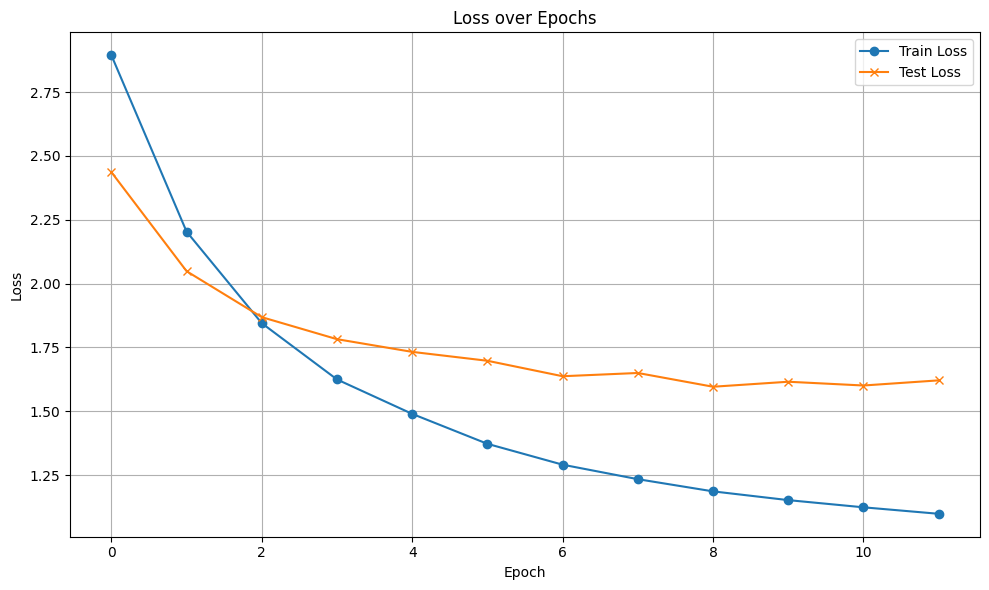

In [68]:
# —— Plot Loss Curve —— 
plt.figure(figsize=(10, 6))
plt.plot(train_loss_history, label='Train Loss', marker='o')
plt.plot(test_loss_history, label='Test Loss', marker='x')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("loss_plot.png") 
plt.show()


/tmp/ipykernel_36/4289916112.py:62: UserWarning: Glyph 128309 (\N{LARGE BLUE CIRCLE}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_36/4289916112.py:62: UserWarning: Glyph 128994 (\N{LARGE GREEN CIRCLE}) missing from current font.
  plt.tight_layout()


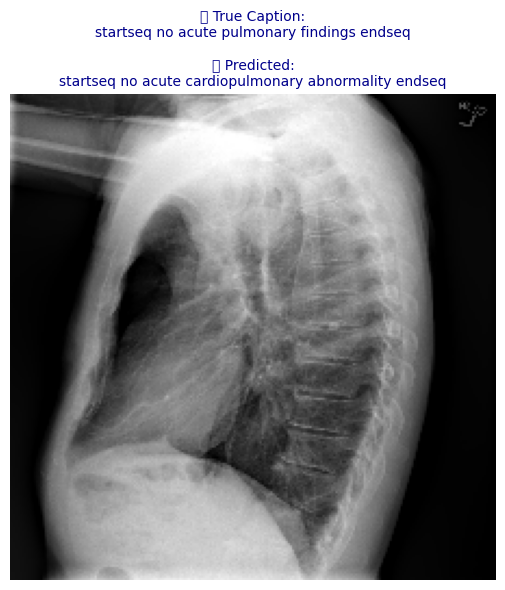

Predicted Caption: startseq no acute cardiopulmonary abnormality endseq


In [90]:
import random
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.densenet import preprocess_input
from keras.preprocessing.sequence import pad_sequences
import torch
import torch.nn.functional as F

def predict_random_test_caption(model_2,
                                 feature_model_chexnet,
                                 tokenizer,
                                 test_mapping,
                                 test_img_dir,
                                 max_length,
                                 device):
    # Choose random test image ID
    img_id = random.choice(list(test_mapping.keys()))
    caption_true = test_mapping[img_id]

    # Resolve image path
    img_path = os.path.join(test_img_dir, img_id + '.dcm.png')

    # Load and preprocess image
    img = load_img(img_path, target_size=(224, 224), color_mode='rgb')
    x = img_to_array(img)[None, ...]
    x = preprocess_input(x)
    feat = feature_model_chexnet.predict(x, verbose=0).flatten()
    img_tensor = torch.tensor(feat, dtype=torch.float32)[None].to(device)

    # Start decoding sequence
    seq = [tokenizer.word_index['startseq']]
    caption_gen = ['startseq']

    model_2.eval()
    with torch.no_grad():
        for _ in range(max_length):
            padded = pad_sequences([seq], maxlen=max_length, padding='post')
            seq_t = torch.tensor(padded, dtype=torch.long).to(device)

            logits = model_2(img_tensor, seq_t)
            probs = F.softmax(logits, dim=-1)
            yhat = probs.argmax(dim=-1).item()

            word = tokenizer.index_word.get(yhat, None)
            if word is None:
                break

            caption_gen.append(word)
            seq.append(yhat)

            if word == 'endseq':
                break

    caption_gen_str = ' '.join(caption_gen)

    # Display image + captions
    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"🔵 True Caption:\n{caption_true}\n\n🟢 Predicted:\n{caption_gen_str}",
              fontsize=10, loc='center', color='darkblue')
    plt.tight_layout()
    plt.show()

    return caption_gen_str

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
result = predict_random_test_caption(
    model_2=model_2,
    feature_model_chexnet=feature_model_chexnet,
    tokenizer=tokenizer,
    test_mapping=test_mapping,
    test_img_dir='/kaggle/input/chest-xrays-indiana-university/images/images_normalized',
    max_length=max_length,
    device=device
)
print("Predicted Caption:", result)

In [87]:
def predict_caption(model_2,
                    feature_model_chexnet,
                    tokenizer,
                    image_path,
                    max_length,
                    device):
    # Extract image features
    img = load_img(image_path, target_size=(224, 224))
    x = img_to_array(img)[None, ...]
    x = preprocess_input(x)
    # Disable any internal progress bar in model prediction by setting verbose=0
    feat = feature_model_chexnet.predict(x, verbose=0).flatten()
    img_tensor = torch.tensor(feat, dtype=torch.float32)[None].to(device)

    # Start with the 'startseq' token
    seq = [tokenizer.word_index['startseq']]
    caption = ['startseq']

    model_2.eval()
    with torch.no_grad():
        for _ in range(max_length):
            # Pad sequence and convert to tensor
            padded = pad_sequences([seq], maxlen=max_length, padding='post')
            seq_t = torch.tensor(padded, dtype=torch.long).to(device)

            # One step prediction
            logits = model_2(img_tensor, seq_t)
            probs = F.softmax(logits, dim=-1)
            yhat = probs.argmax(dim=-1).item()

            # Convert index to word
            word = tokenizer.index_word.get(yhat, None)
            if word is None:
                break

            # Append the predicted word to the caption
            caption.append(word)
            seq.append(yhat)

            # Stop if 'endseq' is generated
            if word == 'endseq':
                break

    return ' '.join(caption)
# ===== مثال استفاده =====
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
result = predict_caption(
    model_2=model_2,
    feature_model_chexnet=feature_model_chexnet,
    tokenizer=tokenizer,
    image_path="/kaggle/input/chest-xrays-indiana-university/images/images_normalized/1000_IM-0003-1001.dcm.png",
    max_length=max_length,
    device=device
)
print("Predicted Caption:", result)

Predicted Caption: startseq no acute cardiopulmonary abnormality endseq


In [80]:
import os
import torch
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction
from tqdm import tqdm  # For terminal version; use tqdm.notebook in Jupyter

def evaluate_model_bleu(model_2,
                        feature_model_chexnet,
                        tokenizer,
                        test_mapping,
                        test_img_dir,
                        max_length,
                        device):
    predictions = {}
    references = {}

    for image_id, true_caption in tqdm(test_mapping.items(), desc="Evaluating"):
        # Construct image path
        image_filename = image_id + ".dcm.png"
        image_path = os.path.join(test_img_dir, image_filename)

        # Generate prediction
        predicted_caption = predict_caption(model_2,
                                            feature_model_chexnet,
                                            tokenizer,
                                            image_path,
                                            max_length,
                                            device)

        # Tokenize
        pred_tokens = predicted_caption.split()
        ref_tokens = true_caption.split()

        predictions[image_id] = pred_tokens
        references[image_id] = [ref_tokens]

    # Prepare for BLEU computation
    list_of_references = [references[img_id] for img_id in predictions.keys()]
    hypotheses_tokens = [predictions[img_id] for img_id in predictions.keys()]
    smooth_fn = SmoothingFunction().method0

    # BLEU scores
    bleu1 = corpus_bleu(list_of_references, hypotheses_tokens, weights=(1, 0, 0, 0))
    bleu2 = corpus_bleu(list_of_references, hypotheses_tokens, weights=(0.5, 0.5, 0, 0))
    bleu0 = corpus_bleu(list_of_references, hypotheses_tokens, weights=(1, 0, 0, 0), smoothing_function=smooth_fn)

    print("✅ BLEU-1: {:.4f}".format(bleu1))
    print("✅ BLEU-2: {:.4f}".format(bleu2))
    print("✅ BLEU0 (with smoothing method0): {:.4f}".format(bleu0))



image_dir = "/kaggle/input/chest-xrays-indiana-university/images/images_normalized"

evaluate_model_bleu(model_2=model_2,
                    feature_model_chexnet=feature_model_chexnet,
                    tokenizer=tokenizer,
                    test_mapping=test_mapping,
                    test_img_dir=image_dir,
                    max_length=max_length,
                    device=device)

Evaluating: 100%|██████████| 1250/1250 [02:53<00:00,  7.20it/s]


✅ BLEU-1: 0.5194
✅ BLEU-2: 0.3857
✅ BLEU0 (with smoothing method0): 0.5194
